### **Retrain Model on Augmented Image**

**The model is loaded and retrained on augmented data, which includes cropping, rotating and random flipping, in order to improve performance**

In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb: 512'

In [47]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
import sys
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
import random

import ast
import re

import json
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
# root path
root_path = 'C:/Users/KurtJi/OneDrive - University of Illinois - Urbana/Desktop/Personal Projects/data/inaturalist/'

In [4]:
# Hyper parameters
num_epochs = 8
num_classes = 4
batch_size = 64
learning_rate = 0.002

#### **Reconstruct Model Structure**

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [304]:
# Added convolution layers
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.avg = nn.AvgPool2d(8)
        self.fc1 = nn.Linear(512 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        x = x.view(-1, 512 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## **Load Data**

In [8]:
mbra_df = pd.read_csv('mbra_dataset.csv')
mbra_df = mbra_df.sample(n=5000).reset_index(drop=True)

n = 3833
img_name = mbra_df.iloc[n, 0]
class_name = mbra_df.loc[n, 'class']
common_name = mbra_df.loc[n, 'common_name']

print('Image name: {}'.format(img_name))
print(class_name, common_name)

Image name: train_mini/03416_Animalia_Chordata_Aves_Charadriiformes_Laridae_Larus_fuscus/6439cdaf-72a1-4772-abe1-73d83cef4695.jpg
Aves Lesser Black-backed Gull


### **Dataset Class**

In [9]:
class MbraDataset(Dataset):
    """Face label dataset."""

    def __init__(self, df, root_dir, csv_file=None, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if csv_file:
            self.df = pd.read_csv(csv_file)
        else:
            self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    # def __getitem__(self, idx):
    #     if torch.is_tensor(idx):
    #         idx = idx.tolist()

    #     img_path = os.path.join(self.root_dir,
    #                             self.df.iloc[idx, 0])
    #     # print(img_path)
    #     image = io.imread(img_path)
    #     label = self.df.iloc[idx, 1]
    #     sample = {'image': image, 'label': label}

    #     if self.transform:
    #         sample = self.transform(sample)

    #     return sample

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = io.imread(img_path) # Load the image using skimage.io
        label = self.df.iloc[idx, 1]

        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [10]:
# get the dataframe with only the image and the class level name
mbra_df_class = mbra_df[['image_path', 'class']].copy()

In [11]:
from sklearn import preprocessing

class_labels = mbra_df_class['class'].tolist()

le = preprocessing.LabelEncoder()
encoded_labels = le.fit_transform(class_labels)

# Create a label map (class_name -> encoded_integer)
class_map = dict(zip(encoded_labels, class_labels))


mbra_df_class['class'] = encoded_labels

mbra_df_class.head()

,image_path,class
0,train_mini/03106_Animalia_Chordata_Amphibia_Ca...,0
1,train_mini/04544_Animalia_Chordata_Aves_Strigi...,1
2,train_mini/04437_Animalia_Chordata_Aves_Picifo...,1
3,train_mini/04734_Animalia_Chordata_Mammalia_Di...,2
4,train_mini/04413_Animalia_Chordata_Aves_Peleca...,1


In [12]:
class_map

{0: 'Amphibia', 1: 'Aves', 2: 'Mammalia', 3: 'Reptilia'}

### **Implementing Augmentation**

In [276]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        # if isinstance(self.output_size, int):
        #     if h > w:
        #         new_h, new_w = self.output_size * h / w, self.output_size
        #     else:
        #         new_h, new_w = self.output_size, self.output_size * w / h
        # else:
        new_h, new_w = self.output_size, self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for label because for images,
        # x and y axes are axis 1 and 0 respectively
        # label = label * [new_w / w, new_h / h]

        return {'image': img, 'label': label}

# crop at the center
class CenterCrop(object):
    
    def __init__(self, crop_size):
        assert isinstance(crop_size, (int, tuple))
        self.crop_size = crop_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        # if isinstance(self.output_size, int):
        #     if h > w:
        #         new_h, new_w = self.output_size * h / w, self.output_size
        #     else:
        #         new_h, new_w = self.output_size, self.output_size * w / h
        # else:
        new_h, new_w = self.crop_size, self.crop_size
        new_h, new_w = int(new_h), int(new_w)

        img = image[h - new_h: h, w - new_w: w]
        return {'image': img, 'label': label}
    
# random rotation
class RandomRotate(object):
    
    def __init__(self, angle):
        assert isinstance(angle, (int, tuple))
        self.angle = angle

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        rotate = v2.RandomRotation(degrees=random.uniform(0,self.angle))

        # Convert the rotated tensor back to a numpy array
        # Apply the transformation to the image
        img = torch.from_numpy(image.T.copy())
        # print(img.shape)
        # print(type(img))
        # print(img)
        img = rotate(img)
        # print(img.shape)
        img = img.numpy()
        # print(type(img))
        # print(img)

        # Convert the rotated tensor back to a numpy array
        # img = img.numpy()
        return {'image': img.copy().T, 'label': label}

# flip by a probability
class RandomFlip(object):
    
    def __init__(self, flip_prob):
        assert isinstance(flip_prob, (float, tuple))
        self.flip_prob = flip_prob

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        flip = v2.RandomHorizontalFlip(p=self.flip_prob)

        # Convert the rotated tensor back to a numpy array
        # Apply the transformation to the image
        img = torch.from_numpy(image.T.copy())
        # print(img.shape)
        # print(type(img))
        # print(img)
        img = flip(img)
        # print(img.shape)
        img = img.numpy()

        return {'image': img.copy().T, 'label': label}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        # return {'image': torch.from_numpy(image),
        #         'label': torch.as_tensor((label,))}
        return {'image': torch.from_numpy(image).float(),  # convert the image to a float Tensor
                'label': label}  # keep the label as an integer

#### **Image Augmentation**

**Reference**: https://towardsdatascience.com/a-comprehensive-guide-to-image-augmentation-using-pytorch-fb162f2444be

In [14]:
from sklearn import preprocessing
import torch

In [261]:
mbra_data_class = MbraDataset(df = mbra_df_class,
                                           root_dir=root_path,
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               ToTensor()
                                           ]))

In [313]:
mbra_data_class_aug = MbraDataset(df = mbra_df_class,
                                           root_dir=root_path,
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               CenterCrop(224),
                                               Rescale(256),
                                               RandomRotate(180),
                                               RandomFlip(0.5),
                                               ToTensor()
                                           ]))

In [286]:
mbra_data_class_aug[i]['label']

1

**Check Augmentation Results**

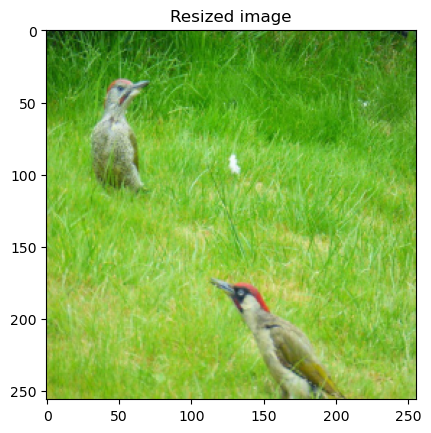

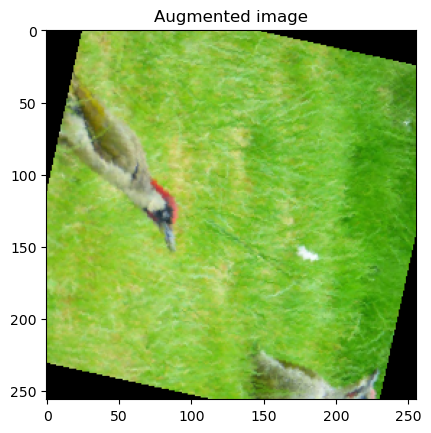

In [314]:
i = 3512
fig = plt.figure()
sample = mbra_data_class[i]['image']

plt.title('Resized image')
plt.imshow(sample.T.permute(1,0,2))
plt.show()

# check augmented
sample1 = mbra_data_class_aug[i]['image']


plt.title('Augmented image')
plt.imshow(sample1.T.permute(1,0,2))
plt.show()

### **Retrain model on augmented data**

#### **Train/Test Split**

In [344]:
train_size = int(0.8 * len(mbra_data_class))
test_size = len(mbra_data_class) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(mbra_data_class, [train_size, test_size])
# use the augmented data for training and raw data for testing
train_dataset = mbra_data_class_aug

In [345]:
for i, sample in enumerate(train_dataset):
    print(i, sample['image'].size(), sample['label'])

    if i == 5:
        break

0 torch.Size([3, 256, 256]) 0
1 torch.Size([3, 256, 256]) 1
2 torch.Size([3, 256, 256]) 1
3 torch.Size([3, 256, 256]) 2
4 torch.Size([3, 256, 256]) 1
5 torch.Size([3, 256, 256]) 3


In [346]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=batch_size//2,
                        shuffle=False, num_workers=0)

In [347]:
len(train_loader)

79

#### **Check device**

In [348]:
!conda info --envs

# conda environments:
#
                         C:\Users\KurtJi\AppData\Local\R-MINI~1
                         C:\Users\KurtJi\AppData\Local\R-MINI~1\envs\r-reticulate
                         C:\Users\KurtJi\AppData\Local\r-miniconda
                         C:\Users\KurtJi\anaconda3
                         C:\Users\KurtJi\miniconda3
base                  *  c:\Users\KurtJi\anaconda3



In [349]:
torch.cuda.is_available()

True

In [350]:
import torch
import time
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.cuda.current_device()
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070 Laptop GPU'

In [351]:
# import gc
# del variables
# gc.collect()
model = SimpleCNN().to(device)
# Load saved model parameters
# Load state_dict
model.load_state_dict(torch.load('simplecnn_sample_dict.pth'))
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

model.cuda()
dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor

In [352]:
num_epochs = 24

In [353]:
# Record the start time
start_time = time.time()

# Train the model
total_step = len(train_loader)
print('# of batches', total_step)

# record loss
losses = []

for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader):  # replace 'data_loader' with your actual DataLoader
        images = batch['image']
        labels = batch['label']
        # print(type(images), type(labels))
        # images = images.to(device)
        # # print(images)
        # labels = labels.to(device)
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda() 
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        losses.append(loss)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            

# Record the end time
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")


# of batches 79
Epoch [1/24], Step [1/79], Loss: 0.8619


In [ ]:
import time

# Record the start time
start_time = time.time()

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(test_loader):  # replace 'data_loader' with your actual DataLoader
        images = batch['image']
        labels = batch['label']
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the 1000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'simplecnn_sample_dict.pth')
# Save the model checkpoint
torch.save(model, 'simplecnn_sample.pth')

# Record the end time
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

KeyboardInterrupt: 

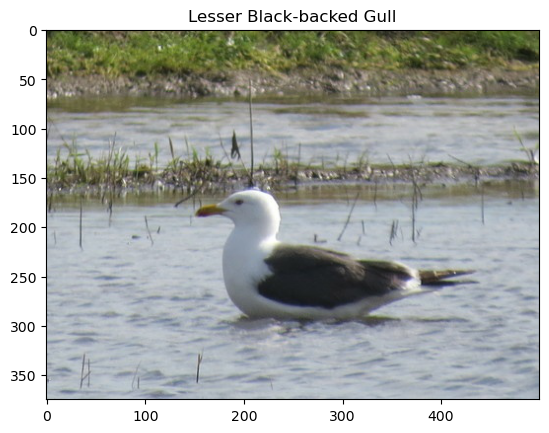

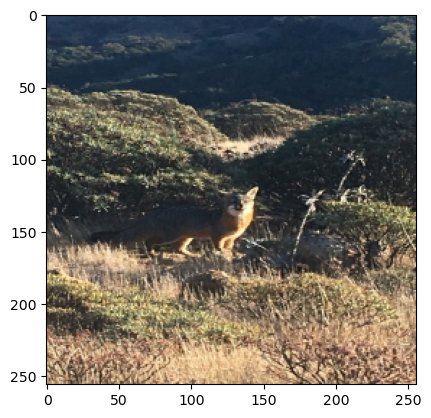

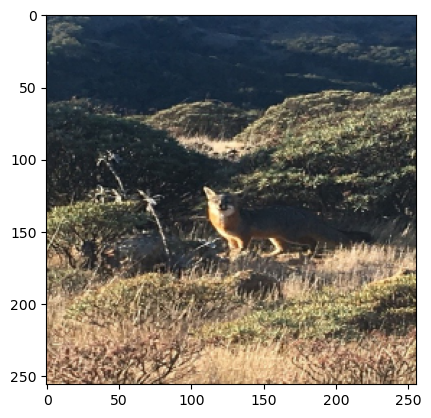

In [258]:
def show_animals(image, label):
    """Show image with label"""
    plt.title(label)
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated
    # Add a title to the plot


plt.figure()
show_animals(io.imread(os.path.join(root_path, img_name)),
               common_name)
plt.show()

augmentation = v2.Compose([
    v2.Resize(size=(256,256)),
    #v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.CenterCrop(size=224),
    v2.RandomRotation(degrees=random.uniform(0,120)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = mbra_data_class[700]['image']

plt.imshow(image.T.permute(1,0,2))
plt.show()
flip = v2.RandomHorizontalFlip(p=0.5)
img = flip(image)

# print(image.shape, img.shape)
# print(type(image), type(img))
# print(image, img)

plt.imshow(img.T.permute(1,0,2))
plt.show()